In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import *

In [4]:
import tensorflow as tf
import numpy as np

In [5]:
from gensim import models

okt_model = models.word2vec.Word2Vec.load('NaverMovie_okt_wo_jep.model')

In [6]:
import pandas as pd

In [7]:
train_data = pd.read_csv('ratings_train.txt',sep='\t').dropna().reset_index(drop=True)
test_data = pd.read_csv('ratings_test.txt',sep='\t').dropna().reset_index(drop=True)

training_sentences = []
testing_sentences = []

In [8]:
documents = []
for item in train_data.document:
    documents.append(item)

labels = []
for item in train_data.label:
    labels.append(item)

In [9]:
test_documents = []
for item in test_data.document:
    test_documents.append(item)

test_labels = []
for item in test_data.label:
    test_labels.append(item)

In [10]:
vocab_size = 20000
embedding_dim = 200
max_length = 41
trunc_type='post'
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(documents)

In [11]:
word_index = tokenizer.word_index
text_sequences = tokenizer.texts_to_sequences(documents)
print(len(word_index))
print(word_index)

padded = pad_sequences(text_sequences,maxlen=max_length,truncating = 'pre')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
testing_sequences = tokenizer.texts_to_sequences(test_documents)
test_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [13]:
len(word_index)

296311

In [14]:
print(padded[0])
print(padded.shape)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   24  937    5 6728 1098]
(149995, 41)


In [15]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

index = 0 
for word, idx in tokenizer.word_index.items():
    try:
        embedding_vector = okt_model.wv.__getitem__(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    except Exception as e:
        pass
        
embedding_matrix.shape

(20000, 200)

In [16]:
training_labels_final = np.array(labels)
testing_labels_final = np.array(test_labels)

In [17]:
sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                            embedding_dim,
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)
x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy',min_delta=0.002,patience=1,mode='max')

In [21]:
history = model.fit(padded, training_labels_final, epochs = 30, validation_data = (test_padded, testing_labels_final),callbacks=[es])

Epoch 1/30
4688/4688 [==============================] - 84s 18ms/step - loss: 0.5677 - accuracy: 0.6834 - val_loss: 0.4994 - val_accuracy: 0.7393
Epoch 2/30
4688/4688 [==============================] - 85s 18ms/step - loss: 0.4386 - accuracy: 0.7809 - val_loss: 0.4832 - val_accuracy: 0.7540
Epoch 3/30
4688/4688 [==============================] - 84s 18ms/step - loss: 0.3581 - accuracy: 0.8244 - val_loss: 0.5083 - val_accuracy: 0.7545


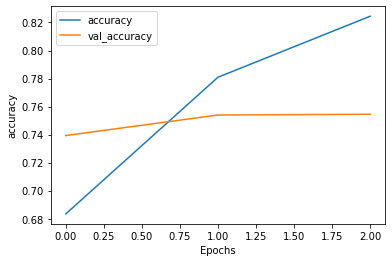

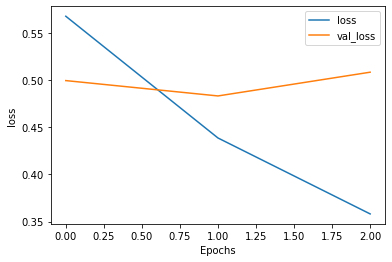

In [22]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
model.save('word2vec_okt200_model/0.7545_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: word2vec_okt200_model/0.7545_model/assets


In [2]:
import tensorflow as tf

In [24]:
okt_remodel = tf.keras.models.load_model('word2vec_okt200_model/0.7545_model')

## val_loss 를 기준으로 재훈련

In [25]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',min_delta=0.002,patience=1,mode='min')

In [26]:
num_epochs = 30
re_history = okt_remodel.fit(padded, training_labels_final, epochs = num_epochs, validation_data = (test_padded, testing_labels_final), callbacks=[es])
re_history

Epoch 1/30
4688/4688 [==============================] - 270s 58ms/step - loss: 0.3918 - accuracy: 0.8148 - val_loss: 0.3997 - val_accuracy: 0.8079
Epoch 2/30
4688/4688 [==============================] - 264s 56ms/step - loss: 0.2373 - accuracy: 0.8869 - val_loss: 0.4763 - val_accuracy: 0.7979
